In [1]:
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt

from qibo import hamiltonians, set_backend
from qibo.models.dbi.double_bracket import DoubleBracketGeneratorType, DoubleBracketScheduling, DoubleBracketIteration, DoubleBracketCost
from qibo.models.dbi.utils import *
from qibo.models.dbi.utils_scheduling import *

### Normalization of D

In [2]:
# Hamiltonian
set_backend("numpy")
# hamiltonian parameters
nqubits = 7
h = 3.0

# define the hamiltonian
H_TFIM = hamiltonians.TFIM(nqubits=nqubits, h=h)

# define the least-squares cost function
cost = DoubleBracketCost.least_squares
# initialize class
dbi = DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.single_commutator,cost=cost)

[Qibo 0.2.7|INFO|2024-04-01 22:40:49]: Using numpy backend on /CPU:0


In [5]:
factor = np.array([1,2**nqubits])
s_space = np.linspace(1e-5, 1.0, 100)
off_diagonal_norm_diff = np.empty((len(factor)+1,len(s_space)))
potential = np.empty((len(factor),len(s_space)))
for i in range(len(factor)):
# generate data for plotting sigma decrease of the first step
    d = np.diag(np.linspace(1,2**nqubits,2**nqubits))/factor[i]
    for s in range(len(s_space)):
        dbi_eval = deepcopy(dbi)
        dbi_eval(s_space[s],d=d)
        off_diagonal_norm_diff[i,s] = (dbi_eval.off_diagonal_norm - dbi.off_diagonal_norm)
        potential[i,s] = dbi_eval.least_squares(d=d)
    """
    # grid_search
    step_grid = dbi.choose_step(scheduling=DoubleBracketScheduling.grid_search,d=d)
    print('grid_search step:', step_grid)
    # hyperopt
    step_hyperopt = dbi.choose_step(scheduling=DoubleBracketScheduling.hyperopt,d=d, max_evals=100, step_max=0.6)
    print('hyperopt_search step:', step_hyperopt)
    # polynomial
    step_poly = dbi.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation,d=d, n=3)
    print('polynomial_approximation step:', step_poly)
    """
d = np.diag(np.linspace(1,2**nqubits,2**nqubits))
step = 1e-2
iterations = 200



Text(0, 0.5, 'Least squares cost function')

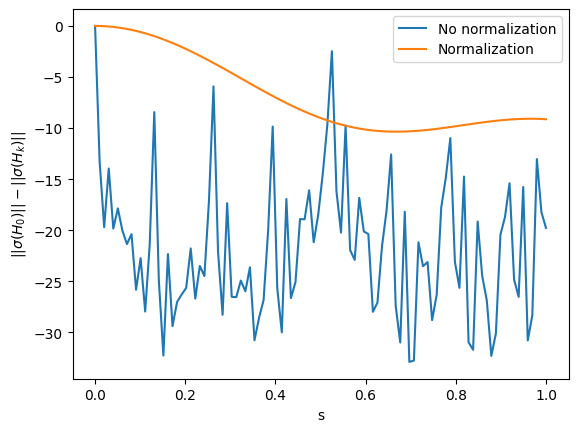

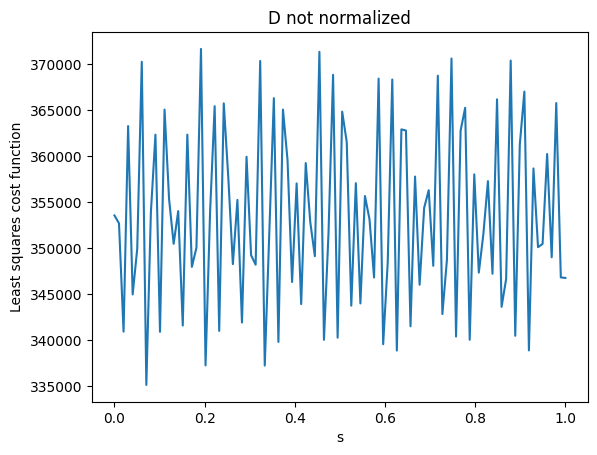

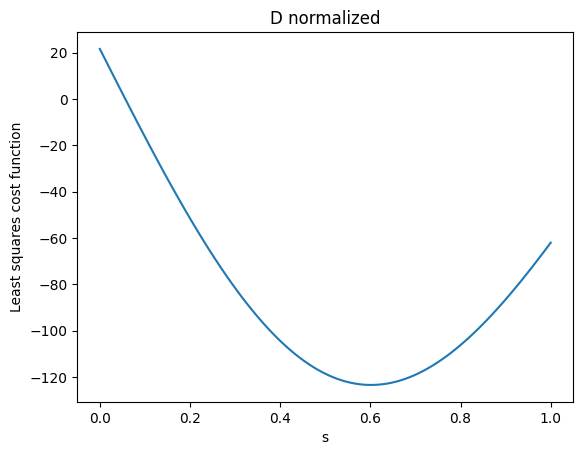

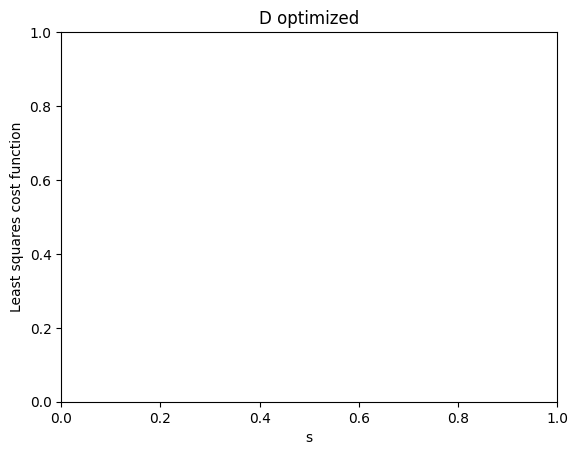

In [6]:
# Plot the results
plt.figure()
plt.plot(s_space, off_diagonal_norm_diff[0,:],label= 'No normalization')
plt.plot(s_space, off_diagonal_norm_diff[1,:],label= 'Normalization')
plt.xlabel('s')
plt.ylabel(r'$||\sigma(H_0)||-||\sigma(H_k)||$')
plt.legend()

plt.figure()
plt.title('D not normalized')
plt.plot(s_space, potential[0,:],label= 'No normalization')
plt.xlabel('s')
plt.ylabel('Least squares cost function')

plt.figure()
plt.title('D normalized')
plt.plot(s_space, potential[1,:],label= 'Normalization')
plt.xlabel('s')
plt.ylabel('Least squares cost function')


In [94]:
dbi = DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.single_commutator,cost=cost)
dbi_eval = deepcopy(dbi)
d = np.diag(np.linspace(1,2**nqubits,2**nqubits))
flows = 50
off_diagonal_norm = np.empty((flows+1,3))
off_diagonal_norm[0,:] = dbi_eval.off_diagonal_norm
for i in range(flows):
    step_poly = dbi_eval.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation,d=d)
    dbi_eval(step_poly,d=d)
    off_diagonal_norm[i+1,0] = dbi_eval.off_diagonal_norm


d = np.diag(np.linspace(1,2**nqubits,2**nqubits))/2**nqubits
dbi_eval = deepcopy(dbi)
for i in range(flows):
    step_poly = dbi_eval.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation,d=d)
    dbi_eval(step_poly,d=d)
    off_diagonal_norm[i+1,1] = dbi_eval.off_diagonal_norm

dbi_eval = deepcopy(dbi)
d = np.diag(np.linspace(1,2**nqubits,2**nqubits))
step = 1e-2
iterations = 200
d, loss, grad, diags = gradient_ascent(dbi_eval, d,step, iterations)
for i in range(flows):
    step_poly = dbi_eval.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation,d=d)
    dbi_eval(step_poly,d=d)
    off_diagonal_norm[i+1,2] = dbi_eval.off_diagonal_norm


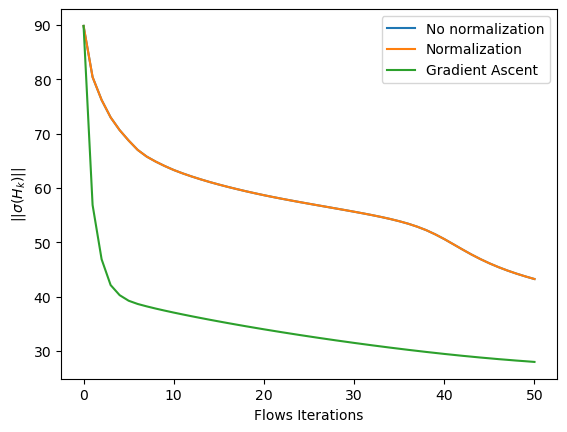

In [95]:
plt.figure()
plt.plot(off_diagonal_norm[:,0],label= 'No normalization')
plt.plot(off_diagonal_norm[:,1],label= 'Normalization')
plt.plot(off_diagonal_norm[:,2],label= 'Gradient Ascent')
plt.xlabel('Flows Iterations')
plt.ylabel(r'$||\sigma(H_k)||$')
plt.legend()

### Hyperopt does it get stuck

In [9]:
# Hamiltonian
set_backend("numpy")

# hamiltonian parameters
nqubits = 7
h = 3.0

# define the hamiltonian
H_TFIM = hamiltonians.TFIM(nqubits=nqubits, h=h)

# define the least-squares cost function
cost = DoubleBracketCost.least_squares
# initialize class
dbi = DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.single_commutator,cost=cost)

[Qibo 0.2.7|INFO|2024-04-01 22:42:14]: Using numpy backend on /CPU:0


In [11]:
dbi = DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.single_commutator,cost=cost)
dbi_eval = deepcopy(dbi)
d = np.diag(np.linspace(1,2**nqubits,2**nqubits))
flows = 10
off_diagonal_norm = np.empty(flows+1)
off_diagonal_norm[0] = dbi_eval.off_diagonal_norm
for i in range(flows):
    step_poly = dbi_eval.choose_step(scheduling=DoubleBracketScheduling.hyperopt,d=d)
    dbi_eval(step_poly,d=d)
    off_diagonal_norm[i+1] = dbi_eval.off_diagonal_norm


100%|██████████| 500/500 [00:30<00:00, 16.47trial/s, best loss: 327316.4158512455]


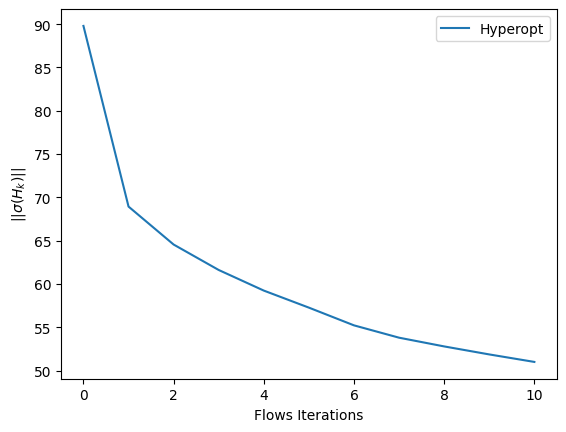

In [12]:
plt.figure()
plt.plot(off_diagonal_norm[:],label= 'Hyperopt')
plt.xlabel('Flows Iterations')
plt.ylabel(r'$||\sigma(H_k)||$')
plt.legend()

### Difference between numerical gradients and analytic ones


In [14]:
# Hamiltonian
set_backend("numpy")

# hamiltonian parameters
nqubits = 7
h = 3.0

# define the hamiltonian
H_TFIM = hamiltonians.TFIM(nqubits=nqubits, h=h)

# define the least-squares cost function
cost = DoubleBracketCost.least_squares
# initialize class
dbi = DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.single_commutator,cost=cost)

[Qibo 0.2.7|INFO|2024-04-01 22:50:13]: Using numpy backend on /CPU:0


In [20]:
nqubits = [3,4,5,6,7]
iterations = 50
step = 1e-2
differences = np.empty((len(nqubits),iterations+1))
loss_max = np.empty(len(nqubits))
for q in range(len(nqubits)):
    # define the hamiltonian
    H_TFIM = hamiltonians.TFIM(nqubits=nqubits[q], h=h)

    # define the least-squares cost function
    cost = DoubleBracketCost.least_squares
    # initialize class
    dbi = DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.single_commutator,cost=cost)
    loss_max [q] = dbi.least_squares(d=np.diag(np.linspace(1,2**nqubits[q],2**nqubits[q])))
    params = np.linspace(1,2**nqubits[q],2**nqubits[q])
    d_analytic, loss_analytic, grad_analytic, diags_analytic = gradient_descent(dbi, params, iterations, step)
    params = np.linspace(1,2**nqubits[q],2**nqubits[q])
    d_numerical, loss_numerical, grad_numerical, diags_numerical = gradient_descent(dbi, params,iterations,step, analytic=False)
    differences[q,:] = loss_analytic - loss_numerical


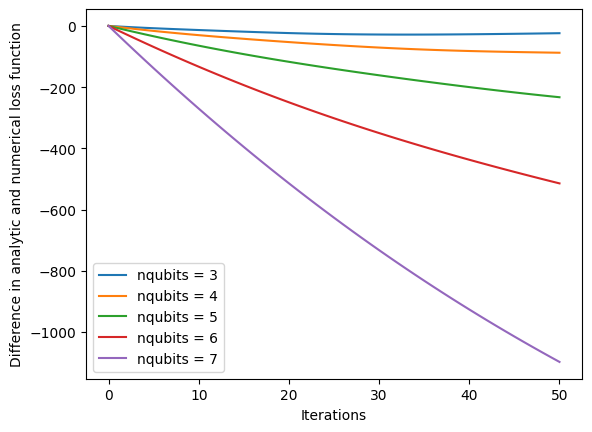

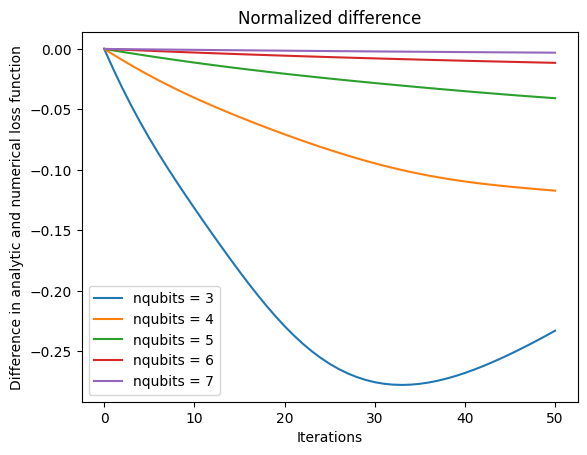

In [21]:
plt.figure()
for q in range(len(nqubits)):
    plt.plot(differences[q,:],label= 'nqubits = {}'.format(nqubits[q]))
plt.xlabel('Iterations')
plt.ylabel('Difference in analytic and numerical loss function')
plt.legend()

plt.figure()
plt.title('Normalized difference')
for q in range(len(nqubits)):
    plt.plot(differences[q,:]/loss_max[q],label= 'nqubits = {}'.format(nqubits[q]))
plt.xlabel('Iterations')
plt.ylabel('Difference in analytic and numerical loss function')
plt.legend()


### Difference in optimization moments


In [49]:
# Hamiltonian
set_backend("qibojit", "numba")

# hamiltonian parameters
nqubits = 7
h = 3.0

# define the hamiltonian
H_TFIM = hamiltonians.TFIM(nqubits=nqubits, h=h)

# define the least-squares cost function
cost = DoubleBracketCost.least_squares
# initialize class
dbi = DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.single_commutator,cost=cost)


[Qibo 0.2.5|INFO|2024-03-21 14:44:56]: Using qibojit (numba) backend on /CPU:0


In [75]:
flows = 100
dbi_eval = deepcopy(dbi)
dbi_eval2 = deepcopy(dbi)
d_not_optimized = np.diag(np.linspace(1,2**nqubits,2**nqubits))
d = np.diag(np.linspace(1,2**nqubits,2**nqubits))
step = 1e-2
iterations = 100
d_optimized, loss, grad, diags = gradient_descen(dbi_eval, d,step, iterations,analytic=False)
off_diagonal_norm = np.empty((flows+1,3))
off_diagonal_norm[0] = dbi_eval.off_diagonal_norm
for i in range(flows):
    step_poly = dbi_eval.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation,d=d)
    dbi_eval(step_poly,d=d)
    step_poly = dbi_eval2.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation,d=d_not_optimized)
    dbi_eval2(step_poly,d=d_not_optimized)
    off_diagonal_norm[i+1,0] = dbi_eval.off_diagonal_norm
    off_diagonal_norm[i+1,1] = dbi_eval2.off_diagonal_norm

dbi_eval3 = deepcopy(dbi)
d = np.diag(np.linspace(1,2**nqubits,2**nqubits))
for i in range(flows):
    d = np.diag(np.linspace(1,2**nqubits,2**nqubits))
    d_opt, loss, grad, diags = gradient_ascent(dbi_eval3, d,step, 20,analytic=False)
    step_poly = dbi_eval3.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation,d=d_opt)
    dbi_eval3(step_poly,d=d_opt)
    off_diagonal_norm[i+1,2] = dbi_eval3.off_diagonal_norm   

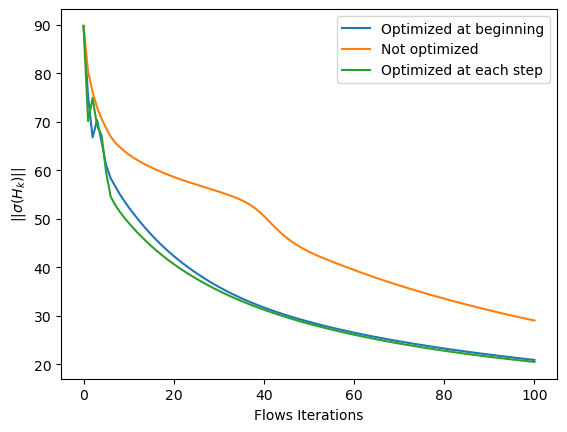

In [76]:
plt.figure()
plt.plot(off_diagonal_norm[:,0],label= 'Optimized at beginning')
plt.plot(off_diagonal_norm[:,1],label= 'Not optimized')
plt.plot(off_diagonal_norm[:,2],label= 'Optimized at each step')
plt.xlabel('Flows Iterations')
plt.ylabel(r'$||\sigma(H_k)||$')
plt.legend()


In [23]:
# Hamiltonian
set_backend("numpy")

# hamiltonian parameters
nqubits = 7
h = 3.0

# define the hamiltonian
H_TFIM = hamiltonians.TFIM(nqubits=nqubits, h=h)

# define the least-squares cost function
cost = DoubleBracketCost.least_squares
# initialize class
dbi = DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.single_commutator,cost=cost)

[Qibo 0.2.7|INFO|2024-04-01 23:01:13]: Using numpy backend on /CPU:0


In [24]:
end = np.linspace(1.1,10*2**nqubits,100)
loss = np.empty(100)
spacing = np.empty(100)
for i in range(100):
    dbi_eval = deepcopy(dbi)
    d = np.diag(np.linspace(1,end[i],2**nqubits))
    spacing[i] = d[1,1] - d[0,0]
    step_poly = dbi_eval.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation,d=d,n = 3)
    dbi_eval(step_poly,d=d)
    loss[i] = dbi_eval.off_diagonal_norm

Text(0, 0.5, 'Loss function')

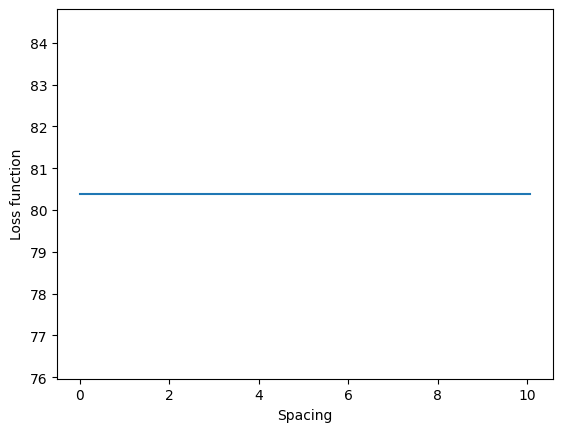

In [25]:
plt.figure()
plt.plot(spacing,loss)
plt.xlabel('Spacing')
plt.ylabel('Loss function')


In [9]:
def d_poly_spacing(nqubits,degree):
    d = np.empty(2**nqubits)
    for i in range(len(d)):
        d[i] = 1 + i**degree
    return np.diag(d)


In [24]:
degrees = np.linspace(0.1,5,100)
nqubits = [3,4,5,7]
h = 3.0

loss = np.empty((100,len(nqubits)))
best_degree = np.empty(len(nqubits))
for q in range(len(nqubits)):
    H_TFIM = hamiltonians.TFIM(nqubits=nqubits[q], h=h)
    dbi = DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.single_commutator,cost=cost)
    for i in range(100):
        dbi_eval = deepcopy(dbi)
        d = d_poly_spacing(nqubits[q],degrees[i])
        step_poly = dbi_eval.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation,d=d,n = 3)
        dbi_eval(step_poly,d=d)
        loss[i,q] = dbi_eval.off_diagonal_norm
    best_degree[q] = degrees[np.argmin(loss[:,q])]


[1.18888889 1.13939394 1.13939394 1.13939394]


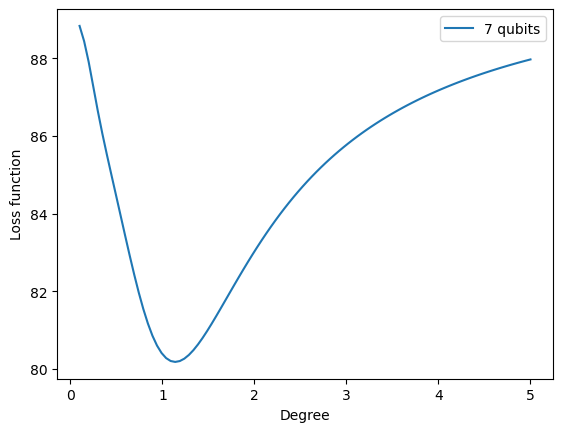

In [26]:
plt.figure()
plt.plot(degrees,loss[:,3],label = f'{nqubits[q]} qubits')
plt.xlabel('Degree')
plt.ylabel('Loss function')
plt.legend()
print(best_degree)

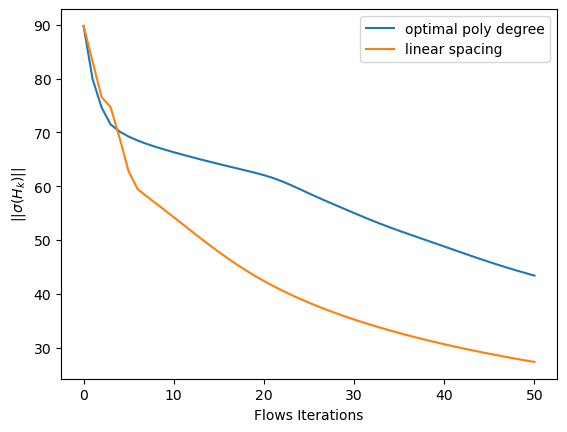

In [32]:
n_qubits = 7
d = d_poly_spacing(n_qubits,best_degree[2])
step = 1e-2
iterations = 50
H_TFIM = hamiltonians.TFIM(nqubits=n_qubits, h=h)
dbi = DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.single_commutator,cost=cost)
d_optimized, loss, grad, diags = gradient_ascent(dbi, d,step, iterations,analytic=False)

flows = 50
off_diagonal_norm = np.empty((flows+1,2))
off_diagonal_norm[0,:] = dbi.off_diagonal_norm
for i in range(flows):
    step_poly = dbi.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation,d=d_optimized)
    dbi(step_poly,d=d_optimized)
    off_diagonal_norm[i+1,0] = dbi.off_diagonal_norm

d = d_poly_spacing(n_qubits,1)
dbi2 = DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.single_commutator,cost=cost)
d_optimized, loss, grad, diags = gradient_ascent(dbi2, d,step, iterations,analytic=False)
for i in range(flows):
    step_poly = dbi2.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation,d=d_optimized)
    dbi2(step_poly,d=d_optimized)
    off_diagonal_norm[i+1,1] = dbi2.off_diagonal_norm

plt.figure()
plt.plot(off_diagonal_norm[:,0],label= 'optimal poly degree')
plt.plot(off_diagonal_norm[:,1],label= 'linear spacing')
plt.xlabel('Flows Iterations')
plt.ylabel(r'$||\sigma(H_k)||$')
plt.legend()



In [239]:
def delta_to_d(delta):
    d = np.empty(len(delta)+1)
    d[0] = 1
    for i in range(len(d)-1):
        d[i+1] = d[i] + delta[i]
    return np.diag(d)

def d_to_delta(d):
    delta = np.empty(len(d)-1)
    for i in range(len(d)-1):
        delta[i] = d[i+1,i+1]-d[i,i]
    return delta

def polynomial(x, coefficients):
    y = np.empty(len(x))
    for i in range(len(coefficients)):
        y += coefficients[i]*x**i
    return y

def gradient_delta_polynomial(dbi, coefficients,h=1e-5):
    grad = np.empty(len(coefficients))
    dim = dbi.h.matrix.shape[0]
    delta = polynomial(np.linspace(0,1,dim),coefficients)
    d = delta_to_d(delta)
    dbi_eval = deepcopy(dbi)
    angle = dbi_eval.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation,d=d)
    dbi_eval(angle,d=d)
    norm = dbi_eval.off_diagonal_norm
    for i in range(len(grad)):
        new_coeff = np.copy(coefficients)
        new_coeff[i] += h
        new_delta = polynomial(np.linspace(0,1,dim), new_coeff)
        new_d = delta_to_d(new_delta)
        dbi_eval = deepcopy(dbi)
        angle = dbi_eval.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation,d=new_d)
        dbi_eval(angle,d=new_d)
        new_norm = dbi_eval.off_diagonal_norm
        grad[i] = (new_norm-norm)/h

    return grad


def optimize_poly(dbi, step, iterations, degree):
    coefficients = np.random.rand(degree)
    dim = dbi.h.matrix.shape[0]
    delta = polynomial(np.linspace(0,1,dim),coefficients)
    d = delta_to_d(delta)
    loss = np.empty(iterations)
    grad = np.empty(degree)
    for i in range(iterations):
        dbi_eval = deepcopy(dbi)
        step_poly = dbi_eval.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation,d=d)
        dbi_eval(step_poly,d=d)
        loss[i] = dbi_eval.off_diagonal_norm
        grad = gradient_delta_polynomial(dbi_eval, coefficients)
        coefficients -= step*grad
        delta = polynomial(np.linspace(0,1,dim),coefficients)
        d = delta_to_d(delta)
    return coefficients, loss, grad



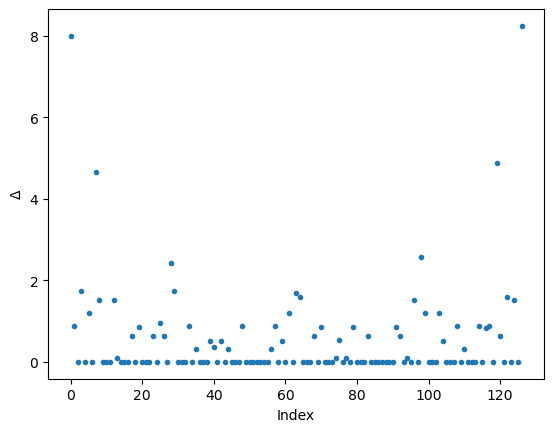

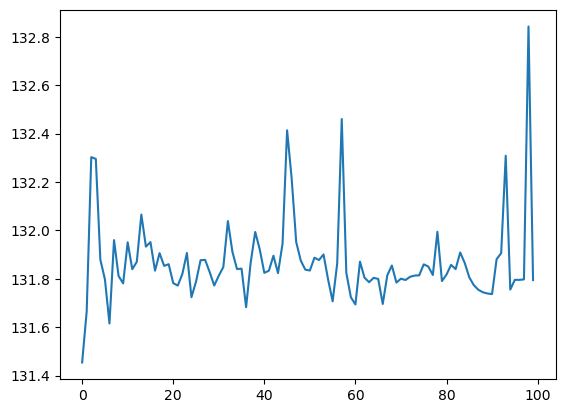

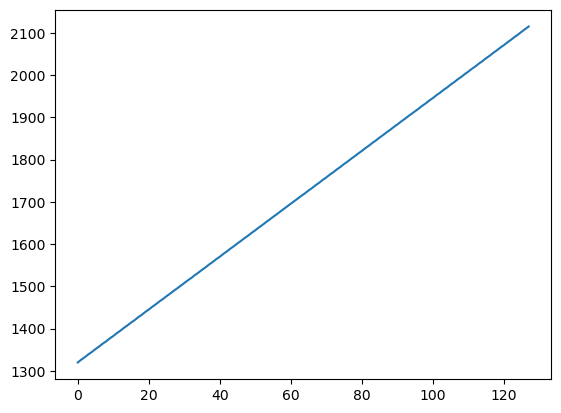

In [207]:
H_TFIM = hamiltonians.TFIM(nqubits=7, h=5.0)
dbi = DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.single_commutator,cost=cost)
matrix = dbi.h.matrix
eigenenergies = np.diag(np.linalg.eigh(matrix)[0])
delta = d_to_delta(eigenenergies)

plt.figure()
plt.plot(delta,'.')
plt.xlabel('Index')
plt.ylabel(r'$\Delta$')

coefficients, loss, grad = optimize_poly(dbi, 1e-3, 100, 2)
plt.figure()
plt.plot(loss)
poly = polynomial(np.linspace(0,1,2**7),coefficients)
plt.figure()
plt.plot(poly)

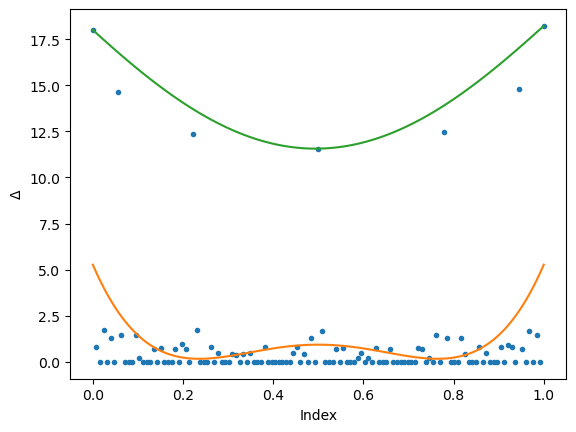

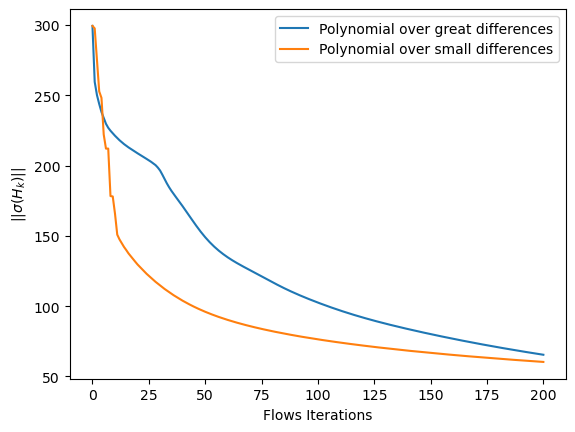

In [286]:
nqubits = 7
H_TFIM = hamiltonians.TFIM(nqubits=nqubits, h=10.0)
dbi = DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.single_commutator,cost=cost)
matrix = dbi.h.matrix
eigenenergies = np.diag(np.linalg.eigh(matrix)[0])
delta = d_to_delta(eigenenergies)
def remove_zeros(vector,epsilon = 3):
    return vector[vector>epsilon]
delta_plus = remove_zeros(delta)
x = np.linspace(0,1,len(delta))
p1 = np.polynomial.Polynomial.fit(x,delta,4)
plt.figure()
plt.plot(x,delta,'.')
plt.plot(x,p1(x))
x = np.linspace(0,1,len(delta_plus))
p2 = np.polynomial.Polynomial.fit(x,delta_plus,4)
x = np.linspace(0,1,100)
plt.plot(x,p2(x))
plt.xlabel('Index')
plt.ylabel(r'$\Delta$')

flows = 200
off_diagonal_norm = np.empty((flows+1,2))
x = np.linspace(0,1,2**nqubits-1)
delta = p2(x)
d = delta_to_d(delta)
d /= d[-1,-1] 
dbi = DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.single_commutator,cost=cost)
off_diagonal_norm[0,:]  = dbi.off_diagonal_norm
for i in range(flows):
    step_poly = dbi.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation,d=d)
    dbi(step_poly,d=d)
    off_diagonal_norm[i+1,0] = dbi.off_diagonal_norm

delta = p1(x)
d = delta_to_d(delta)
d /= d[-1,-1]
dbi = DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.single_commutator,cost=cost)
for i in range(flows):
    step_poly = dbi.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation,d=d)
    dbi(step_poly,d=d)
    off_diagonal_norm[i+1,1] = dbi.off_diagonal_norm

plt.figure()
plt.plot(off_diagonal_norm[:,0],label='Polynomial over great differences')
plt.plot(off_diagonal_norm[:,1],label='Polynomial over small differences')
plt.xlabel('Flows Iterations')
plt.ylabel(r'$||\sigma(H_k)||$')
plt.legend()



In [ ]:
c = np.linspace(-10,10,100)


### Pauli Ansatz

In [2]:
# Hamiltonian
set_backend("numpy")

# hamiltonian parameters
nqubits = 7
h = 3.0

# define the hamiltonian
H_TFIM = hamiltonians.TFIM(nqubits=nqubits, h=h)

# define the least-squares cost function
cost = DoubleBracketCost.least_squares

# initialize class
dbi = DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.single_commutator,cost=cost)

[Qibo 0.2.7|INFO|2024-04-03 10:06:29]: Using numpy backend on /CPU:0


In [3]:
def Z_decomposition(matrix):
    Z = np.array([[1, 0], [0, -1]])
    params = np.empty(int(np.log2(matrix.shape[0])))
    for i in range(len(params)):
        Z_i = np.kron(np.eye(2**(i)), np.kron(Z, np.eye(2**(len(params)-i-1))))
        params[i] = np.trace(matrix@Z_i)    
    return params


In [18]:
nqubits = [7]
iterations = 100
step = 1e-3
differences = np.empty((len(nqubits),iterations+1))
loss_pauli = np.empty((len(nqubits),iterations+1))
loss_full = np.empty((len(nqubits),iterations+1))
loss_max = np.empty(len(nqubits))
for q in range(len(nqubits)):
    # define the hamiltonian
    H_TFIM = hamiltonians.TFIM(nqubits=nqubits[q], h=h)

    # define the least-squares cost function
    cost = DoubleBracketCost.least_squares
    # initialize class
    dbi = DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.single_commutator,cost=cost)
    loss_max[q] = dbi.least_squares(d=np.diag(np.linspace(1,2**nqubits[q],2**nqubits[q])))
    params = np.linspace(2**nqubits[q],1,2**nqubits[q])
    d_full, loss_full[q,:], grad_full, diags_full = gradient_descent(dbi, params,  iterations, step, analytic=False, ansatz = 'Full')
    params = np.diag(np.linspace(1,2**nqubits[q],2**nqubits[q])/2**nqubits[q])
    params = Z_decomposition(params)
    params = np.linspace(nqubits[q],1,nqubits[q])
    d = d_ansatz(params, type='Pauli')
    d_pauli, loss_pauli[q,:], grad_pauli, diags_pauli = gradient_descent(dbi, params, iterations, step, analytic=False, ansatz = 'Pauli')
    differences[q,:] = loss_full[q,:] - loss_pauli[q,:]


Text(0, 0.5, 'Parameters')

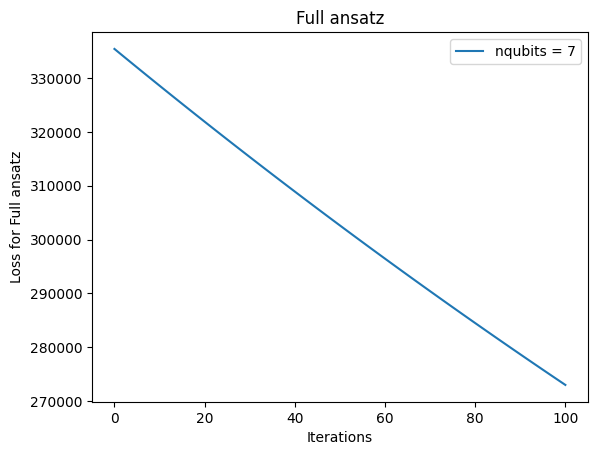

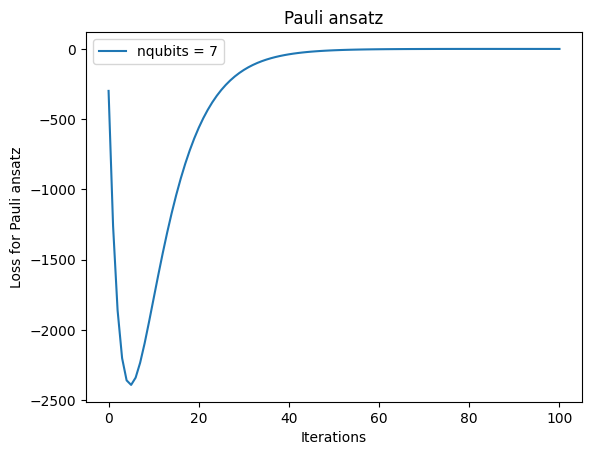

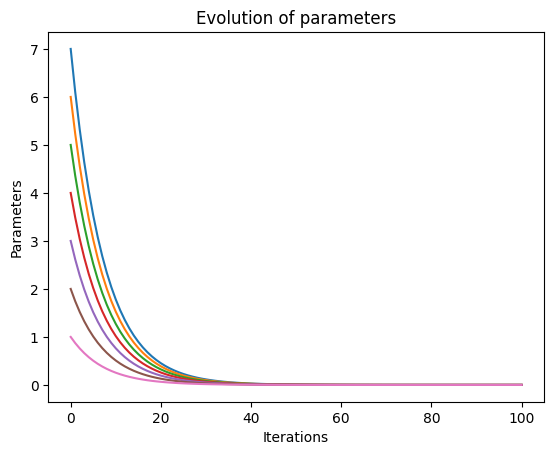

In [19]:
plt.figure()
plt.title('Full ansatz')
plt.plot(loss_full[0,:],label='nqubits = '+str(nqubits[0]))
plt.xlabel('Iterations')
plt.ylabel('Loss for Full ansatz')
plt.legend()

plt.figure()
plt.title('Pauli ansatz')
plt.plot(loss_pauli[0,:],label='nqubits = '+str(nqubits[0]))
plt.xlabel('Iterations')
plt.ylabel('Loss for Pauli ansatz')
plt.legend()

plt.figure()
plt.title('Evolution of parameters')
for i in range(nqubits[0]):
    plt.plot(diags_pauli[i,:])
plt.xlabel('Iterations')
plt.ylabel('Parameters')

In [103]:
nqubits = 7
dbi = DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.single_commutator,cost=cost)
dbi_eval = deepcopy(dbi)
params = np.linspace(1,2**nqubits,2**nqubits)
d_opt, loss_opt, grad_opt, diags_opt = gradient_descent(dbi, params,  100,1e-2, analytic=False, ansatz = 'Full')
flows = 50
off_diagonal_norm = np.empty((flows+1,2))
off_diagonal_norm[0,:] = dbi_eval.off_diagonal_norm
for i in range(flows):
    step_poly = dbi_eval.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation,d=d_opt,n=3)
    dbi_eval(step_poly,d=d_opt)
    off_diagonal_norm[i+1,0] = dbi_eval.off_diagonal_norm



dbi_eval = deepcopy(dbi)
params = np.linspace(7,1,7)
d_opt, loss_opt, grad_opt, diags_opt = gradient_descent(dbi, params,  30, 1e-3, analytic=False, ansatz = 'Pauli')
best = np.argmin(loss_opt)
d_opt = d_ansatz(diags_opt[:,best], type='Pauli')
for i in range(flows):
    step_poly = dbi_eval.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation,d=d_opt,n=3)
    dbi_eval(step_poly,d=d_opt)
    off_diagonal_norm[i+1,1] = dbi_eval.off_diagonal_norm



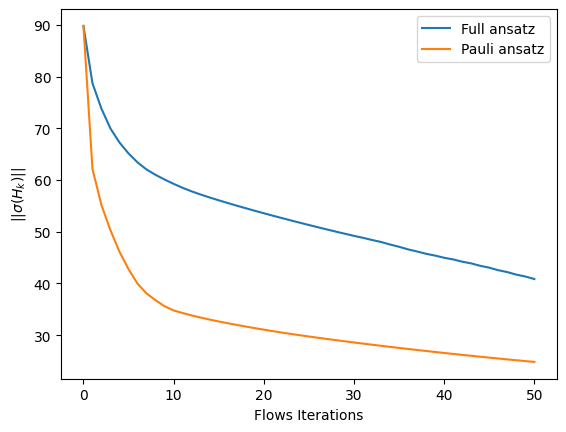

In [105]:
plt.figure()
plt.plot(off_diagonal_norm[:,0],label='Full ansatz')
plt.plot(off_diagonal_norm[:,1],label='Pauli ansatz')
plt.xlabel('Flows Iterations')
plt.ylabel(r'$||\sigma(H_k)||$')
plt.legend()

In [97]:
def random_hamiltonian(nqubits):
    n = 2**nqubits
    h = np.random.rand(n,n)
    h = h + h.T
    return h

In [99]:
tests = 100
nqubits = 5
flows = 50
losses = np.empty((tests,flows))
losses_pauli = np.empty((tests,flows))
for i in range(tests):
    h = random_hamiltonian(nqubits)
    H = hamiltonians.Hamiltonian(nqubits,h)
    dbi = DoubleBracketIteration(H,mode=DoubleBracketGeneratorType.single_commutator,cost=cost)
    dbi_eval = deepcopy(dbi)
    params = np.linspace(1,2**nqubits,2**nqubits)
    d_opt, loss_opt, grad_opt, diags_opt = gradient_descent(dbi, params,  100,1e-2, analytic=False, ansatz = 'Full')

    for j in range(flows):
        step_poly = dbi_eval.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation,d=d_opt)
        dbi_eval(step_poly,d=d_opt)
        losses[i,j] = dbi_eval.off_diagonal_norm
    
    H = hamiltonians.Hamiltonian(nqubits,h)
    dbi = DoubleBracketIteration(H,mode=DoubleBracketGeneratorType.single_commutator,cost=cost)
    dbi_eval = deepcopy(dbi)
    params = np.linspace(nqubits,1,nqubits)
    d_opt, loss_opt, grad_opt, diags_opt = gradient_descent(dbi, params,  5, 1e-3, analytic=False, ansatz = 'Pauli')
    for j in range(flows):
        step_poly = dbi_eval.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation,d=d_opt,n=3)
        dbi_eval(step_poly,d=d_opt)
        losses_pauli[i,j] = dbi_eval.off_diagonal_norm




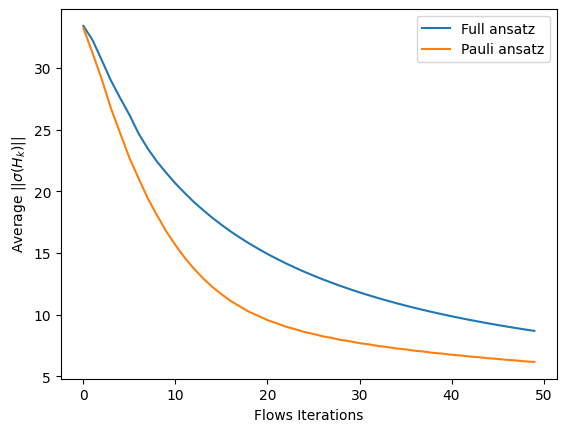

In [100]:
plt.figure()
plt.plot(np.mean(losses,axis=0),label='Full ansatz')
plt.plot(np.mean(losses_pauli,axis=0),label='Pauli ansatz')
plt.xlabel('Flows Iterations')
plt.ylabel(r'Average $||\sigma(H_k)||$')
plt.legend()

In [21]:
# Hamiltonian
set_backend("numpy")

# hamiltonian parameters
nqubits = 2
h = 3.0

# define the hamiltonian
H_TFIM = hamiltonians.TFIM(nqubits=nqubits, h=h)

# define the least-squares cost function
cost = DoubleBracketCost.least_squares

# initialize class
dbi = DoubleBracketIteration(deepcopy(H_TFIM),mode=DoubleBracketGeneratorType.single_commutator,cost=cost)

[Qibo 0.2.7|INFO|2024-04-03 10:15:40]: Using numpy backend on /CPU:0


Text(0, 0.5, 'Step')

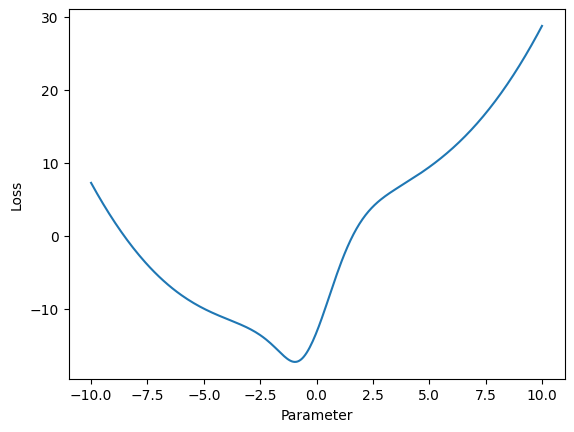

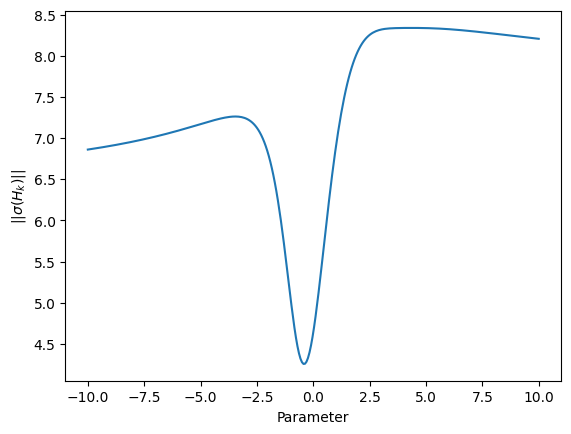

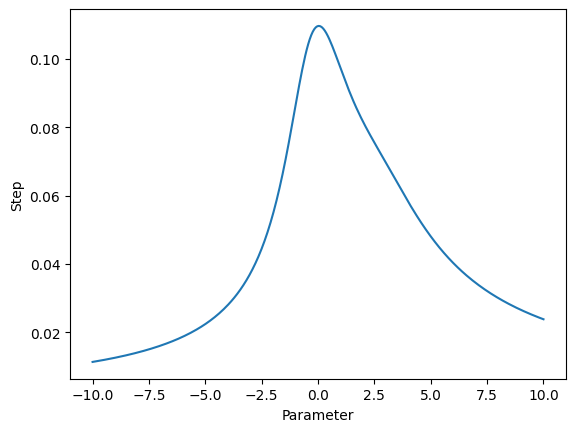

In [94]:
evals = 300
par1 = np.linspace(-10,10,evals)
par2 = 1
par3 = 2
par4 = 4
steps = np.empty(evals)
loss = np.empty(evals)
off_diagonal_norm = np.empty(evals)
for i in range(evals):
    dbi_eval = deepcopy(dbi)
    d = d_ansatz([par1[i],par2,par3,par4],type='Full')
    poly_step = dbi.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation,d=d,n=3)
    dbi_eval(poly_step,d=d)
    steps[i] = poly_step
    loss[i] = dbi_eval.least_squares(d)
    off_diagonal_norm[i] = dbi_eval.off_diagonal_norm

plt.figure()
plt.plot(par1,loss)
plt.xlabel('Parameter')
plt.ylabel('Loss')

plt.figure()
plt.plot(par1,off_diagonal_norm)
plt.xlabel('Parameter')
plt.ylabel(r'$||\sigma(H_k)||$')

plt.figure()
plt.plot(par1,steps)
plt.xlabel('Parameter')
plt.ylabel('Step')




Text(0, 0.5, 'Step size')

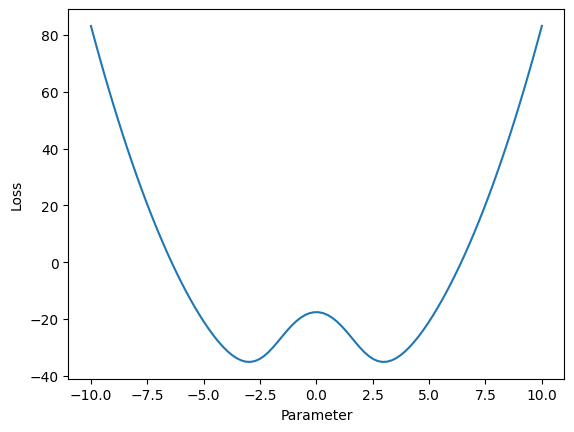

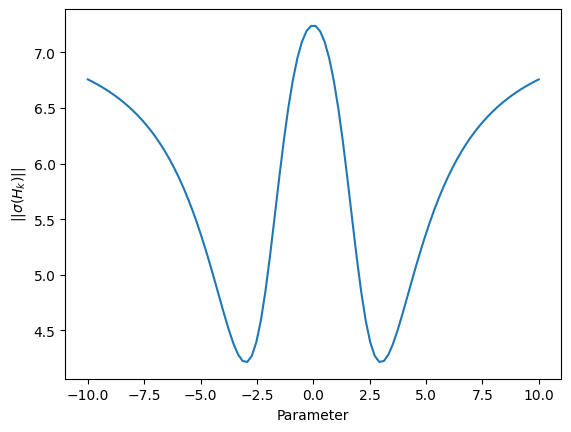

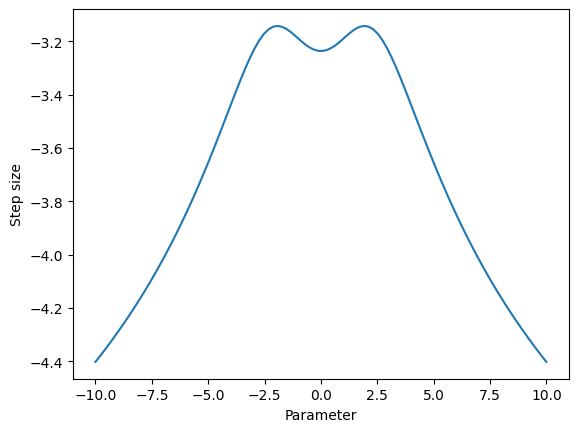

In [95]:
evals = 100
par1 = np.linspace(-10,10,evals)
par2 = -3
steps = np.empty(evals)
loss = np.empty(evals)
off_diagonal_norm = np.empty(evals)
for i in range(evals):
    dbi_eval = deepcopy(dbi)
    d = d_ansatz([par1[i],par2],type='Pauli')
    poly_step = dbi.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation,d=d,n=3)
    steps[i] = poly_step
    dbi_eval(poly_step,d=d)
    loss[i] = dbi_eval.least_squares(d)
    off_diagonal_norm[i] = dbi_eval.off_diagonal_norm

plt.figure()
plt.plot(par1,loss)
plt.xlabel('Parameter')
plt.ylabel('Loss')

plt.figure()
plt.plot(par1,off_diagonal_norm)
plt.xlabel('Parameter')
plt.ylabel(r'$||\sigma(H_k)||$')

plt.figure()
plt.plot(par1,np.log(steps))
plt.xlabel('Parameter')
plt.ylabel('Step size')


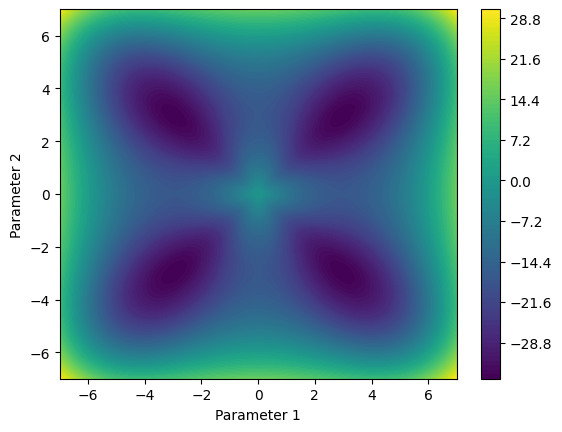

In [24]:
size = 100
par1 = np.linspace(-7,7,size)
par2 = np.linspace(-7,7,size)

loss = np.empty((size,size))

for i in range(size):
    for j in range(size):
        dbi_eval = deepcopy(dbi)
        d = d_ansatz([par1[i],par2[j]],type='Pauli')
        poly_step = dbi.choose_step(scheduling=DoubleBracketScheduling.polynomial_approximation,d=d,n=3)
        dbi_eval(poly_step,d=d)
        loss[i,j] = dbi_eval.least_squares(d)

plt.figure()
plt.contourf(par1,par2,loss,levels=100)
plt.xlabel('Parameter 1')
plt.ylabel('Parameter 2')
plt.colorbar()